# Doing this from scratch

In [1]:
#load requirements for working with PCs
from vedo import *
from ipyvtklink.viewer import ViewInteractiveWidget
import numpy as np
import tensorflow as tf
import time

#limit GPU memory ------------------------------------------------
gpus = tf.config.experimental.list_physical_devices('GPU')
print(gpus)
if gpus:
  try:
    memlim = 2*1024
    tf.config.experimental.set_virtual_device_configuration(gpus[0], [tf.config.experimental.VirtualDeviceConfiguration(memory_limit=memlim)])
  except RuntimeError as e:
    print(e)
#-----------------------------------------------------------------

import sys
import os
current = os.getcwd()
parent_directory = os.path.dirname(current)
sys.path.append(parent_directory)
sys.path.append(parent_directory+"/point_cloud_rectification")
from ICET_spherical import ICET
from linear_corrector import LC

from utils import R_tf
from metpy.calc import lat_lon_grid_deltas
from scipy.spatial.transform import Rotation as R
from matplotlib import pyplot as plt
import copy
import trimesh


from pillow_heif import register_heif_opener
from matplotlib import pyplot as p
from colmapParsingUtils import *
from scipy.spatial.transform import Rotation as R
import cv2

from tqdm import tqdm_notebook as tqdm
from PIL import Image

tf.compat.v1.enable_eager_execution()


%load_ext autoreload
%autoreload 2
%autosave 180
%matplotlib notebook

2023-10-24 22:10:50.733252: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-10-24 22:10:50.838215: E tensorflow/stream_executor/cuda/cuda_blas.cc:2981] Unable to register cuBLAS factory: Attempting to register factory for plugin cuBLAS when one has already been registered
2023-10-24 22:10:51.232440: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory
2023-10-24 22:10:51.232503: W tensorflow/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or 

[PhysicalDevice(name='/physical_device:GPU:0', device_type='GPU')]


2023-10-24 22:10:52.003191: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-24 22:10:52.003377: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-24 22:10:52.003511: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-24 22:10:52.309486: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from SysFS had negative value (-1), but there must be at least one NUMA node, so returning NUMA node zero
2023-10-24 22:10:52.309734: I tensorflow/stream_executor/cuda/cuda_gpu_executor.cc:980] successful NUMA node read from S

Autosaving every 180 seconds


In [2]:
#load raw point cloud data from Newer College Dataset

idx = 500 
fn1 = "/media/derm/06EF-127D4/Newer College Dataset/01_Short_Experiment/point_clouds/frame_" + str(idx) + ".npy"
pc1 = np.load(fn1)
pc1 = np.flip(pc1, axis = 0)#flip to maintain CCW convention

plt = Plotter(N = 1, axes = 1, bg = (1, 1, 1), interactive = True) #axes = 4 (simple), 1(scale)
disp=[]

color = 255*np.linspace(0,1,len(pc1))
cname = np.array([255-color, color, 255-color]).T.tolist()
disp.append(Points(pc1, c=cname,  r = 3.5, alpha =0.5))
print(len(pc1) / 128)

plt.show(disp, "01 Short Experiment Frame #" + str(idx))
ViewInteractiveWidget(plt.window)

512.0


ViewInteractiveWidget(height=960, layout=Layout(height='auto', width='100%'), width=960)

# Convert Point Cloud to 64x1024 "Depth Image"


* Assume point cloud available as xyz coordinates

In [15]:
pc1_spherical = LC.c2s(LC,pc1) #[r, theta, phi]
print(np.shape(pc1_spherical))

depth_image = np.zeros([64, len(pc1_spherical)//64])
# print(np.shape(depth_image))

#nope?
#sort pc1_spherical by azim and elevation angles
pc1_spherical = np.reshape(pc1_spherical, [1024,64,-1])[:,:,0].T
print(np.shape(pc1_spherical))

#set points of radius zero (i.e. non returns) to large values
depth_image = pc1_spherical.copy()
non_return_idx = np.argwhere(depth_image == 0)
# print(non_return_idx)
depth_image[non_return_idx[:,0], non_return_idx[:,1]] = 10

(65536, 3)
(64, 1024)


In [155]:
pc1_spherical = LC.c2s(LC,pc1).numpy() #[r, theta, phi]
pcs = np.reshape(pc1_spherical, [1024,64,-1])
print(np.shape(pcs))


pcs = pcs[np.argsort(pcs, axis = 0)[:,0,0]]
pcs = np.transpose(pcs, [1,0,2])
pcs = pcs[np.argsort(pcs, axis = 0)[:,0,0]]
pcs = np.transpose(pcs, [1,0,2])
print(np.shape(pcs))

# pcs = pcs[np.argsort(pcs, axis = 1)[:,0,0]]
# print(np.shape(pcs))

(1024, 64, 3)
(1024, 64, 3)


<IPython.core.display.Javascript object>


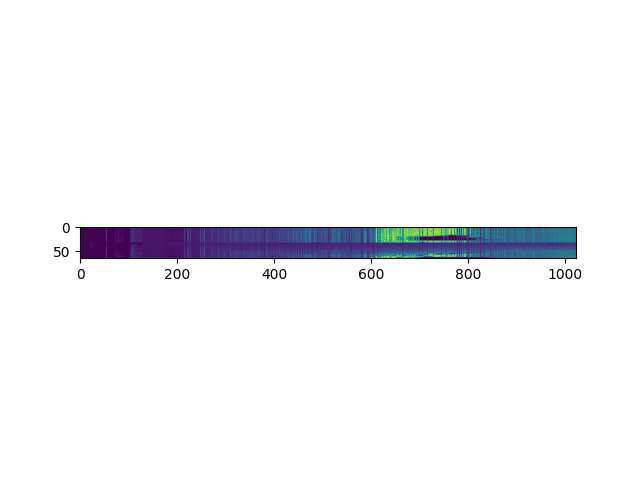

In [156]:
# count = 0
# for h in range(64):
#     for w in range(1024):
#         depth_image[h,w] = pc1_spherical[count,0]
#         count += 1

fig, ax = p.subplots()
p.imshow(pcs[:,:,0].T)#norm="symlog")
# p.imshow(pc1_spherical, cmap = "cool", norm='linear')

In [145]:
a = np.array([[[9, 2, 3],
               [4, 5, 6],
               [7, 0, 5]],
               [[2, 4, 6],
               [4, 5, 3],
               [1, 9, 2]]])
a = a.T 
print(a) #3x3x2

# a.sort(axis = 0)
print("---- \n")

a = a[np.argsort(a, axis = 0)[:,0,0]]
print(a)

a = np.transpose(a, [1,0,2])
a = a[np.argsort(a, axis = 0)[:,0,0]]
a = np.transpose(a, [1,0,2])
print("--- \n ", a)


[[[9 2]
  [4 4]
  [7 1]]

 [[2 4]
  [5 5]
  [0 9]]

 [[3 6]
  [6 3]
  [5 2]]]
---- 

[[[2 4]
  [5 5]
  [0 9]]

 [[3 6]
  [6 3]
  [5 2]]

 [[9 2]
  [4 4]
  [7 1]]]
--- 
  [[[0 9]
  [2 4]
  [5 5]]

 [[5 2]
  [3 6]
  [6 3]]

 [[7 1]
  [9 2]
  [4 4]]]


In [88]:
# np.argsort(b, axis = 2)
print(b.argsort(axis=2))

[[[0 1 2]
  [1 0 2]]

 [[1 0 2]
  [2 0 1]]]
